<a href="https://colab.research.google.com/github/jashvidesai/ORF-Thesis/blob/main/Heterogenous_VRPTW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 73.9 MB/s eta 0:00:00


In [3]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

# Example parameters
V = range(4)  # nodes including depot, 0 is depot
V_star = range(1, 4)  # nodes excluding depot
K = range(3)  # three vehicles with heterogeneous capacities
Q = [10, 15, 20]  # capacity of each vehicle
vehicle_speed = 60  # vehicle speed in km/h

# DISTANCES

np.random.seed(42)
distances = np.random.randint(10, 51, size=(len(V), len(V)))
for i in V:
    distances[i, i] = 0
    for j in range(i + 1, len(V)):
        distances[j, i] = distances[i, j]
for i in V:
    for j in V:
        for k in V:
            if distances[i, j] > distances[i, k] + distances[k, j]:
                distances[i, j] = distances[i, k] + distances[k, j]


t = distances / vehicle_speed  # travel times
c = distances * 0.093  # travel costs (arbitrary scaling for fuel)

# Sample demands (including depot which has 0 demand)
d = [0, 5, 10, 8]

# Time window parameters
a = [0, 10, 15, 20]  # earliest start times
b = [100, 100, 100, 100]  # latest end times
s = [30, 30, 30, 30]  # service times at each node

# Model setup
model = gp.Model("Heterogeneous_VRPTW")

# Decision variables
x = model.addVars(V, V, K, vtype=GRB.BINARY, name="x")  # binary: whether vehicle k travels from i to j
q = model.addVars(V, K, vtype=GRB.CONTINUOUS, name="q")  # continuous: cumulative demand on vehicle k at node i
tau = model.addVars(V, K, vtype=GRB.CONTINUOUS, name="tau")  # continuous: arrival time of vehicle k at node i

# Objective: Minimize total travel cost
model.setObjective(gp.quicksum(c[i, j] * x[i, j, k] for i in V for j in V for k in K if i != j), GRB.MINIMIZE)

# Constraints

# Each customer is visited exactly once
for j in V_star:
    model.addConstr(gp.quicksum(x[i, j, k] for i in V for k in K) == 1, name=f"visit_{j}")

# Each node must be departed from exactly once
for i in V_star:
    model.addConstr(gp.quicksum(x[i, j, k] for j in V for k in K) == 1, name=f"departure_{i}")

###

# Ensure each vehicle returns to the depot at most once
model.addConstrs(
    (gp.quicksum(x[i, 0, k] for i in V_star) <= 1 for k in K),
    name="vehicle_return_depot_once"
)

# Ensure each vehicle departs the depot at most once
model.addConstrs(
    (gp.quicksum(x[0, j, k] for j in V_star) <= 1 for k in K),
    name="vehicle_depart_depot_once"
)

###

# If a vehicle leaves, it must start from the depot
model.addConstrs(
    (gp.quicksum(x[0, j, k] for j in V_star) >= gp.quicksum(x[i, j, k] for i in V for j in V_star)
     for k in K),
    name="leave_from_depot"
)

# If a vehicle returns, it must return to the depot
model.addConstrs(
    (gp.quicksum(x[i, 0, k] for i in V_star) >= gp.quicksum(x[i, j, k] for i in V_star for j in V)
     for k in K),
    name="return_to_depot"
)

# Flow conservation for all nodes and vehicles
model.addConstrs(
    (gp.quicksum(x[i, j, k] for j in V if j != i) == gp.quicksum(x[j, i, k] for j in V if j != i)
    for i in V for k in K),
    name="flow_conservation"
)

###

# Fleet capacity constraint for heterogeneous vehicles
model.addConstr(
    gp.quicksum(Q[k] * gp.quicksum(x[0, j, k] for j in V_star) for k in K) >= sum(d[i] for i in V_star),
    name="fleet_capacity"
)

# Depot load initialization
model.addConstrs(
    (q[0, k] == 0 for k in K),
    name="depot_load"
)

# Load boundaries
model.addConstrs(
    (q[i, k] >= d[i] for i in V_star for k in K),
    name="load_lower_bound"
)
model.addConstrs(
    (q[i, k] <= Q[k] for i in V_star for k in K),
    name="load_upper_bound"
)

# Cumulative load progression - Upper Bound
model.addConstrs(
    (q[i, k] + d[j] <= q[j, k] + Q[k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="load_progression_upper"
)

# Cumulative load progression - Lower Bound
M = {(i, j, k): Q[k] - (d[i] + d[j]) for i in V_star for j in V_star for k in K if i != j}
model.addConstrs(
    (q[i, k] + d[j] >= q[j, k] - M[i, j, k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="load_progression_lower"
)

# Depot time
model.addConstrs(
    (tau[0, k] == 0 for k in K),
    name="depot_time"
)

# Time window bounds
model.addConstrs(
    (a[i] <= tau[i, k] for i in V_star for k in K),
    name="time_window_start"
)
model.addConstrs(
    (tau[i, k] <= b[i] for i in V_star for k in K),
    name="time_window_end"
)

# Service time and travel time continuity
M_2 = {(i, j, k): b[i] - a[j] + s[i] + t[i, j] for i in V_star for j in V_star for k in K if i != j}
model.addConstrs(
    (tau[i, k] + s[i] + t[i, j] <= tau[j, k] + M_2[i, j, k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="service_time"
)

# Solve the model
model.optimize()

# Output results
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found:\n")
    for k in K:
        print(f"--- Routes for Vehicle {k} ---")
        route = [0]  # Start at the depot
        total_cost = 0
        current_node = 0  # Start at depot

        while True:
            found_next = False
            for j in V:  # Look for the next node in the route
                if x[current_node, j, k].x > 0.5 and current_node != j:  # Check valid edge
                    route.append(j)  # Add the node to the route
                    total_cost += c[current_node, j]  # Add travel cost
                    current_node = j  # Move to the next node
                    found_next = True
                    break

            if not found_next or current_node == 0:
                # If no valid next node is found or we return to depot, stop
                break

        # Print the route and cost if the vehicle served at least one customer
        if len(route) > 2:  # Route includes at least one customer
            route.append(0)  # Add the depot at the end
            print(f"Vehicle {k} route: {' -> '.join(map(str, route))}")
            print(f"Total cost for Vehicle {k}: {total_cost:.2f}")
        else:
            print(f"Vehicle {k} is not used.")

    print("\n")
else:
    print("No optimal solution found.")

# Check if demand is fulfilled
print("Demand Fulfillment at Nodes:")
for i in V_star:
    total_demand_fulfilled = sum(q[i, k].x for k in K)  # Total demand satisfied at node i
    print(f"Node {i}: Demand = {d[i]}, Fulfilled = {total_demand_fulfilled:.2f}")

# Check if vehicles are used
print("Vehicle Usage:")
for k in K:
    used = any(x[i, j, k].x > 0.5 for i in V for j in V if i != j)
    print(f"Vehicle {k}: {'Used' if used else 'Not Used'}")

# Print raw decision variables
print("\nDecision Variables:")
for k in K:
    for i in V:
        for j in V:
            if x[i, j, k].x > 0.5:
                print(f"x[{i}, {j}, {k}] = {x[i, j, k].x}")

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 127 rows, 72 columns and 427 nonzeros
Model fingerprint: 0x785f477f
Variable types: 24 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 14.6940000
Presolve removed 121 rows and 63 columns
Presolve time: 0.00s
Presolved: 6 rows, 9 columns, 18 nonzeros
Variable types: 0 continuous, 9 integer (9 binary)

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 2 (of 2 available processors)

Solution count 1: 14.694 

Optimal solution found (tolerance 1.00e

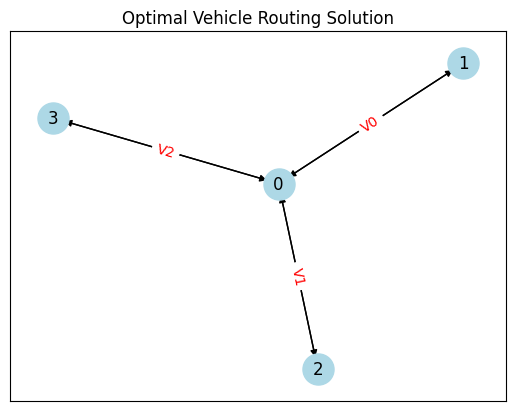

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for i in V:
    G.add_node(i)

# Add edges based on the decision variables
for k in K:
    for i in V:
        for j in V:
            if i != j and x[i, j, k].x > 0.5:  # Include edges with positive flow
                G.add_edge(i, j, label=f"V{k}")

# Draw the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)
nx.draw_networkx_edges(G, pos, edge_color="black", arrows=True)
nx.draw_networkx_labels(G, pos, labels={i: f"{i}" for i in V}, font_size=12)

# Add edge labels
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=10)

plt.title("Optimal Vehicle Routing Solution")
plt.show()